In [1]:
import torch
import torchio as tio
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.insert(1, '../')
from ml.ClassVesselSample import VesselSample
from ml.ClassVesselInferenceAgent import VesselInferenceAgent
from scripts.utils import get_path
from scripts.load_and_save import save_vol_as_nii

**<h1>MIP**

In [2]:
CROP_COEF = 0.08
def transform_to_show(img):
    crop = (np.array(img.shape)*CROP_COEF).astype(int)
    img_out = img[crop[0]:-crop[0], crop[1]:-crop[1]]*1 
    return np.flip(img_out.T, axis=0)

def get_errors_image(MIP_GT, MIP_SEG):
    SIZE = MIP_GT.shape
    Errors = np.zeros((SIZE[0], SIZE[1], 3))

    Errors[:, :, 0][MIP_GT>MIP_SEG] = 1 #Lost vessels -> red
    
    Errors[:, :, 1][(MIP_GT>0)*(MIP_GT==MIP_SEG)] = 0.6 #True values -> green
    Errors[:, :, 2][(MIP_GT>0)*(MIP_GT==MIP_SEG)] = 0.1 #True values -> green

    #Errors[:, :, 2][MIP_GT<MIP_SEG] = 1 # 
    Errors[:, :, 0][MIP_GT<MIP_SEG] = 1
    Errors[:, :, 2][MIP_GT<MIP_SEG] = 1
        
    return(Errors)

In [3]:
model_name = 'LittleUnet'
model_name_with_date = "GenUnet_26_03_2024_01:35"
sample_index = "111"

In [4]:
path_to_sample_dir = f"/home/msst/IXI_MRA_work/IXI{sample_index}"
path_to_SEG = get_path(f'/home/msst/IXI_MRA_work/IXI{sample_index}', key=model_name_with_date)

#GT
sample = VesselSample(path_to_sample_dir)
subject = sample.get_subject()
vessels_GT = subject.vessels.data[0].numpy()
brain = subject.brain.data[0].numpy()
vessels_GT_masked = vessels_GT*brain

#SEG
img = tio.LabelMap(path_to_SEG)
vessels_SEG = img.data[0].numpy()
vessels_SEG_masked = vessels_SEG*brain



#MIP
MIP_GT = transform_to_show(np.max(vessels_GT, axis=2))
MIP_GT_masked = transform_to_show(np.max(vessels_GT_masked, axis=2))

MIP_SEG = transform_to_show(np.max(vessels_SEG, axis=2))
MIP_SEG_masked = transform_to_show(np.max(vessels_SEG_masked, axis=2))

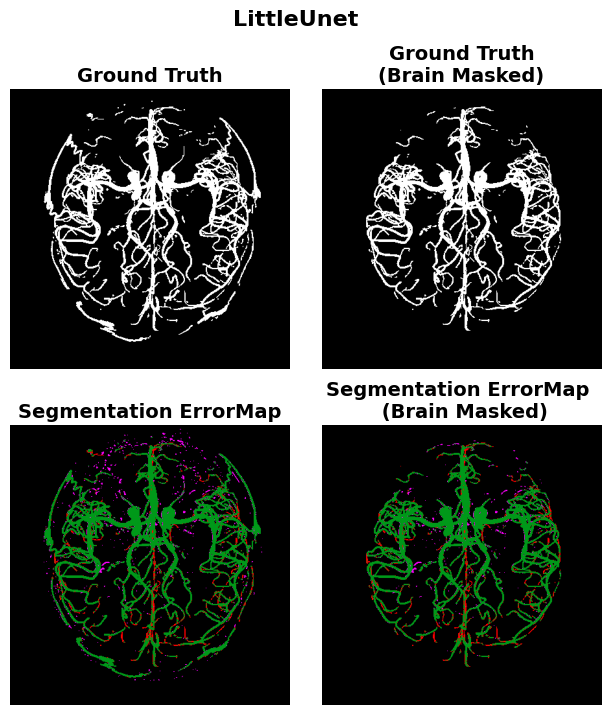

In [5]:
fig, ax = plt.subplots(2, 2, figsize = (8,8), gridspec_kw = {'wspace':0.01, 'hspace':0.2})

ax[0][0].set_axis_off()
ax[0][1].set_axis_off()
ax[1][0].set_axis_off()
ax[1][1].set_axis_off()

ax[0][0].imshow(MIP_GT, cmap='gray')
ax[0][0].set_title("Ground Truth", fontsize = 14, fontweight ='bold') 
ax[0][1].imshow(MIP_GT_masked, cmap='gray')
ax[0][1].set_title("Ground Truth\n(Brain Masked)", fontsize = 14, fontweight ='bold') 

ax[1][0].imshow(get_errors_image(MIP_GT=MIP_GT, MIP_SEG=MIP_SEG))
ax[1][0].set_title("Segmentation ErrorMap", fontsize = 14, fontweight ='bold') 
ax[1][1].imshow(get_errors_image(MIP_GT=MIP_GT_masked, MIP_SEG=MIP_SEG_masked))
ax[1][1].set_title("Segmentation ErrorMap \n (Brain Masked)", fontsize = 14, fontweight ='bold') 

fig.suptitle(f'{model_name}', fontsize=16, fontweight ='bold')

fig.savefig(f'/home/msst/ArticleImages/{model_name_with_date}_results.jpg', dpi=250)

In [6]:
def get_error_vol(vol_GT, vol_SEG):
    assert vol_GT.shape == vol_SEG.shape
    error_vol = np.zeros_like(vol_GT, dtype=np.uint8)
    error_vol[(vol_GT>0)*(vol_GT==vol_SEG)] =1
    error_vol[(vol_GT>vol_SEG)]=2
    error_vol[(vol_GT<vol_SEG)]=3
    return(error_vol)

In [7]:
#error_vol = get_error_vol(vessels_GT_masked, vessels_SEG_masked)

# path_to_save_sample = f'/home/msst/IXI_MRA_work/{sample_name}/{model_name}_ErrorMap.nii.gz'
# save_vol_as_nii(error_vol, subject.head.affine, path_to_save_sample)

**<h1>Learning History**

In [16]:
LOG_PATH = '/home/msst/save_folder/VesselTrainer_log'
DEVICE = 'cuda'

runner_params = {"device" : DEVICE}
runner = VesselInferenceAgent(runner_params)

model_name_with_date = "GenUnet_26_03_2024_02:43"
epoch = 10
history = runner.load_history(get_path(f"{LOG_PATH}/{model_name_with_date}/state_dicts", f'state_dict_epoch_{epoch}'))
list(history.keys())

['train_loss', 'val_loss', 'DICE', 'PR', 'RC', 'SP']

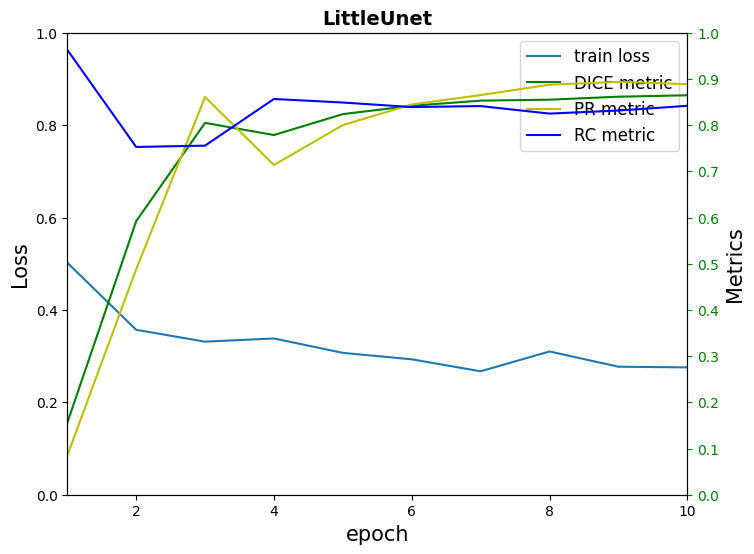

In [39]:
N_ep = len(history['train_loss'])
epochs = np.linspace(1, N_ep, N_ep)

fontsize = 12
fig, ax = plt.subplots(1, 1, figsize=(8, 6)) 

ax.set_title(f"{model_name}", fontsize = 14, fontweight ='bold') 

twin1 = ax.twinx()

plots = []

plots.append(ax.plot(epochs, history['train_loss'], label="train loss")[0])
#plots.append(ax.plot(epochs, history['val_loss'], label="train loss")[0])
plots.append(twin1.plot(epochs, history['DICE'], "g-", label="DICE metric")[0])
plots.append(twin1.plot(epochs, history['PR'], "y-", label="PR metric")[0])
plots.append(twin1.plot(epochs, history['RC'], "b-", label="RC metric")[0])
#plots.append(twin1.plot(epochs, history['SP'], "r-", label="SP metric")[0])



ax.set_xlabel("epoch", fontsize=fontsize+3)
ax.set_ylabel("Loss", fontsize=fontsize+3)
twin1.set_ylabel("Metrics", fontsize=fontsize+3)

twin1.tick_params(axis='y', colors=p3.get_color())

#ax.set_xticklabels(np.linspace(0, 50, 11).astype(int), fontsize=fontsize)
ax.set_xticks(np.linspace(0, N_ep, 6).astype(int))

#ax.set_yticklabels(np.linspace(0, 12, 7).astype(int), fontsize=fontsize)
#ax.set_yticks(np.linspace(0, 12, 7))

#twin1.set_yticklabels(np.round(np.linspace(0, 1, 6),1), fontsize=fontsize)
twin1.set_yticks(np.linspace(0, 1, 11))

ax.set_xlim(1, N_ep)
ax.set_ylim(0, 1)
twin1.set_ylim(0, 1)

ax.legend(handles=plots, fontsize=fontsize)

plt.savefig(f'/home/msst/ArticleImages/{model_name}_learning.jpg', dpi=100)